In [2]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

Top-1 Accuracy: 41.67%
Top-2 Accuracy: 75.00%
Top-3 Accuracy: 83.33%
Top-4 Accuracy: 100.00%
Top-5 Accuracy: 100.00%


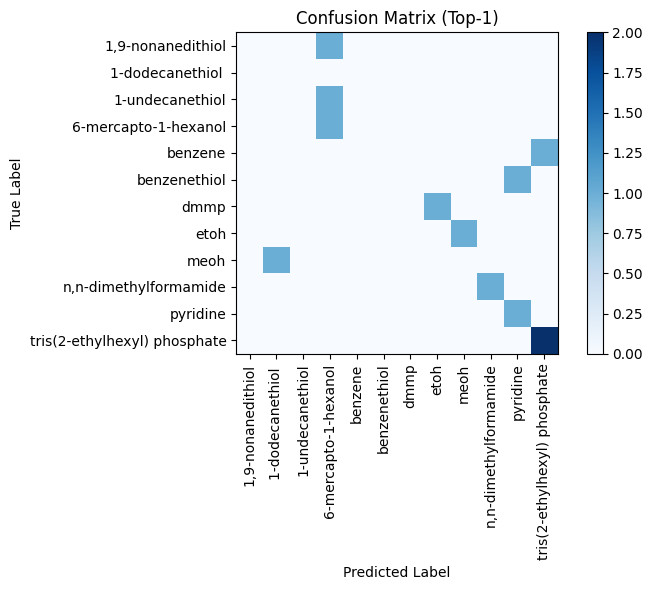

In [3]:
# 1. Load data
ref_df = pd.read_csv('Jesse_Dataset/reference.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')

def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr, lam=1e4, p=0.01, niter=10):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_als(spec, lam=lam, p=p, niter=niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

def smooth(spec, K_smooth=3):
    window = np.ones(K_smooth) / K_smooth
    return np.convolve(spec, window, mode='same')

def build_CP_library(R, Q_len, K_smooth, height, prominence, N_peak, w_max):
    CPs = {}
    Ref_comp = {}
    for chem in np.unique(R[:, -1]):  # assume last column of R is label
        refs = R[R[:, -1] == chem, :-1]
        counts = np.zeros(Q_len, int)
        for spec in refs:
            pks, _ = find_peaks(smooth(spec, K_smooth), height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        comp = []
        hw = w_max // 2
        for spec in refs:
            vec = [np.max(spec[max(0, i - hw): i + hw + 1]) for i in cp_idxs]
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.vstack(comp)
    return CPs, Ref_comp

def CaPSim(query_vector, reference_matrix):
    """
    Compute the mean dot‐product similarity between one query_vector and each row of reference_matrix.
    """
    return np.dot(reference_matrix, query_vector).mean()

# --- Main pipeline ---

def identify_spectrum_pipeline(query_df, ref_df,
    crop_max=1700, lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=12, w_max=15,
    height=0.01, prominence=None):

    # select wavenumber columns
    wav_cols = query_df.columns[:-1]
    wavs = pd.to_numeric(wav_cols)
    keep = wav_cols[wavs < crop_max]

    q = query_df[keep].values.astype(float)
    r = ref_df[keep].values.astype(float)
    r_lbl = ref_df['Label'].values

    # preprocess
    Q = preprocess(q, lam, p, niter)
    R = preprocess(r, lam, p, niter)

    # build CP library (we pass labels along as last column)
    R_with_lbl = np.hstack([R, r_lbl.reshape(-1, 1)])
    CPs, Ref_comp = build_CP_library(R_with_lbl, Q.shape[1],
                                     K_smooth, height, prominence,
                                     N_peak, w_max)

    # identification
    all_rankings = []
    for spec in Q:
        scores = {}
        hw = w_max // 2
        for chem, Rvs in Ref_comp.items():
            vec = [np.max(spec[max(0, i - hw): i + hw + 1]) for i in CPs[chem]]
            qv = minmax_scale(vec)
            scores[chem] = CaPSim(qv, Rvs)
        ranking = sorted(scores, key=scores.get, reverse=True)
        all_rankings.append(ranking)

    return all_rankings, Q, CPs, Ref_comp

# Run pipeline
rankings, Q, CPs, Ref_comp = identify_spectrum_pipeline(query_df, ref_df)

# Extract true labels and Top-k predictions
true_labels = query_df['Label'].values
preds_topk = np.array([[r[k] if k < len(r) else None for k in range(5)]
                       for r in rankings])

# Compute Top-1 through Top-5 accuracies
for k in range(1, 6):
    acc = np.mean([true in pred_row[:k]
                   for true, pred_row in zip(true_labels, preds_topk)])
    print(f"Top-{k} Accuracy: {acc:.2%}")

# Confusion matrix heatmap including all reference classes
all_labels = np.unique(np.concatenate((ref_df['Label'].values,
                                       true_labels)))
pred_top1 = preds_topk[:, 0]

cm = confusion_matrix(true_labels, pred_top1, labels=all_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Top-1)")
plt.colorbar()
plt.xticks(np.arange(len(all_labels)), all_labels, rotation=90)
plt.yticks(np.arange(len(all_labels)), all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()



